<a href="https://colab.research.google.com/github/bedadiggelmann/bina/blob/main/BINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper Functions

Overpass Kanton St. Gallen Abfrage:
https://overpass-turbo.eu/

```
[out:json];
area[name="St. Gallen"][boundary=administrative][admin_level=4];
rel(area)[boundary=administrative][admin_level=8];
out geom;

```





**Data Loading Functions**

This script loads data from a CSV file. Ensure that the path and the encoding match the data file specifics.

In [129]:
def load_data(filepath, encoding='ISO-8859-1', delimiter=';'):
    return pd.read_csv(filepath, encoding=encoding, delimiter=delimiter)

**Data Filtering Functions**

Filters the dataset for specific municipalities using a unique identifier contained in a column.

In [130]:
def filter_data_by_kanton_or_gemeinde(data, column_name, kanton_or_gemeinde_code):
    return data[data[column_name].str.contains(kanton_or_gemeinde_code)]

**Data Extraction Functions**

Extracts yearly data for given conditions and converts non-numeric entries appropriately.

In [131]:
def extract_yearly_data(gemeinde_data, condition_value, typ_value, start_col=4):
    yearly_data = gemeinde_data[
        (gemeinde_data["Anzahl/Anteil"] == condition_value) &
        (gemeinde_data["Leerwohnung (Typ)"].str.contains(typ_value, na=False))
    ].iloc[:, start_col:]
    yearly_data = yearly_data.replace('...', pd.NA)  # Replace '...' with NaN
    yearly_data = yearly_data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors
    years = yearly_data.columns.tolist()  # Get the list of years (column names)
    return yearly_data.iloc[0] if not yearly_data.empty else pd.Series([pd.NA] * len(years), index=years)

**Aggregate Data Functions**

In [132]:
# Helper function to map municipalities to Wahlkreis
def map_municipalities_to_wahlkreis(csv_data):
    wahlkreis_mapping = {
        'Altstätten': 'Rheintal',
        'Au': 'Rheintal',
        'Balgach': 'Rheintal',
        'Berneck': 'Rheintal',
        'Diepoldsau': 'Rheintal',
        'Eichberg': 'Rheintal',
        'Marbach': 'Rheintal',
        'Oberriet': 'Rheintal',
        'Rebstein': 'Rheintal',
        'Rheineck': 'Rheintal',
        'Rüthi': 'Rheintal',
        'St. Margrethen': 'Rheintal',
        'Widnau': 'Rheintal',
        'Berg': 'Rorschach',
        'Goldach': 'Rorschach',
        'Mörschwil': 'Rorschach',
        'Rorschach': 'Rorschach',
        'Rorschacherberg': 'Rorschach',
        'Steinach': 'Rorschach',
        'Thal': 'Rorschach',
        'Tübach': 'Rorschach',
        'Untereggen': 'Rorschach',
        'Bad Ragaz': 'Sarganserland',
        'Flums': 'Sarganserland',
        'Mels': 'Sarganserland',
        'Pfäfers': 'Sarganserland',
        'Quarten': 'Sarganserland',
        'Sargans': 'Sarganserland',
        'Vilters-Wangs': 'Sarganserland',
        'Walenstadt': 'Sarganserland',
        'Amden': 'See-Gaster',
        'Benken': 'See-Gaster',
        'Eschenbach': 'See-Gaster',
        'Gommiswald': 'See-Gaster',
        'Kaltbrunn': 'See-Gaster',
        'Rapperswil-Jona': 'See-Gaster',
        'Schänis': 'See-Gaster',
        'Schmerikon': 'See-Gaster',
        'Uznach': 'See-Gaster',
        'Weesen': 'See-Gaster',
        'Andwil': 'St. Gallen',
        'Eggersriet': 'St. Gallen',
        'Gaiserwald': 'St. Gallen',
        'Gossau': 'St. Gallen',
        'Häggenschwil': 'St. Gallen',
        'Muolen': 'St. Gallen',
        'St. Gallen': 'St. Gallen',
        'Waldkirch': 'St. Gallen',
        'Wittenbach': 'St. Gallen',
        'Bütschwil-Ganterschwil': 'Toggenburg',
        'Ebnat-Kappel': 'Toggenburg',
        'Kirchberg': 'Toggenburg',
        'Lichtensteig': 'Toggenburg',
        'Lütisburg': 'Toggenburg',
        'Mosnang': 'Toggenburg',
        'Neckertal': 'Toggenburg',
        'Nesslau': 'Toggenburg',
        'Wattwil': 'Toggenburg',
        'Wildhaus-Alt St. Johann': 'Toggenburg',
        'Buchs': 'Werdenberg',
        'Gams': 'Werdenberg',
        'Grabs': 'Werdenberg',
        'Sennwald': 'Werdenberg',
        'Sevelen': 'Werdenberg',
        'Wartau': 'Werdenberg',
        'Degersheim': 'Wil',
        'Flawil': 'Wil',
        'Jonschwil': 'Wil',
        'Niederbüren': 'Wil',
        'Niederhelfenschwil': 'Wil',
        'Oberbüren': 'Wil',
        'Oberuzwil': 'Wil',
        'Uzwil': 'Wil',
        'Wil': 'Wil',
        'Zuzwil': 'Wil'
    }

    # Function to map a single row based on the presence of the key in the string
    def map_row(row):
        for key, value in wahlkreis_mapping.items():
            if key in row:
                return value
        return None

    # Update the dataset with a new column for Wahlkreis based on the mapping
    csv_data['Wahlkreis'] = csv_data['Grossregion (<<) / Kanton (-) / Gemeinde (......)'].apply(map_row)
    return csv_data

# Helper function to sum up data by Wahlkreis for specific rows
def sum_data_by_wahlkreis(csv_data):
    # Filter rows that have 'Anzahl Wohnräume - Total' in the second column, 'Leer stehende Wohnung - Total' in the third column and 'Anzahl' in the fourth column
    filtered_data = csv_data[(csv_data.iloc[:, 1] == 'Anzahl Wohnräume - Total') & (csv_data.iloc[:, 2] == 'Leer stehende Wohnung - Total') & (csv_data.iloc[:, 3] == 'Anzahl')]

    # Convert relevant columns to numeric
    numeric_columns = filtered_data.columns[4:-1]
    filtered_data.loc[:, numeric_columns] = filtered_data.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Sum the data by Wahlkreis
    summed_data = filtered_data.groupby('Wahlkreis')[numeric_columns].sum()
    return summed_data

**Plotting Functions**

Functions to plot time series and bar charts for visual comparisons.

In [133]:
def plot_line_chart(data_dict, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(14, 6))
    for label, data in data_dict.items():
        ax.plot(data.index, data.values, label=label, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_bar_chart(data_dict, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(14, 6))
    for label, data in data_dict.items():
        positions = range(len(data.index))
        ax.bar(positions, data.values, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim([0, 3])
    ax.set_xticks(range(len(data.index)))
    ax.set_xticklabels(data.index, rotation=45)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Usage

In [134]:
import pandas as pd

# Lade die CSV-Datei
file_path = 'wohnungen_wahlkreise_kt_stgallen.csv'
data = pd.read_csv(file_path, delimiter=';', encoding='latin1')

# Finde die Zeilen, die zu den Wahlkreisen gehören (>> Wahlkreis)
wahlkreise = data[data['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.startswith('>>')]

# Entferne die ersten beiden Zeichen (>>) und das Wort 'Wahlkreis ' aus dem Wahlkreisnamen
wahlkreise['Kanton (-) / Bezirk (>>) / Gemeinde (......)'] = wahlkreise['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.replace('>> Wahlkreis ', '')

# Definiere die Jahre, die in den Spalten stehen
years = data.columns[4:]

# Summiere die Wohnungen pro Wahlkreis für jedes Jahr
anzahl_wohnungen_pro_wahlkreis = wahlkreise.groupby('Kanton (-) / Bezirk (>>) / Gemeinde (......)')[years].sum()

# Setze die Spalte 'Wahlkreis' als Index
anzahl_wohnungen_pro_wahlkreis.index.name = 'Wahlkreis'

# Setze die Index-Spalte als erste Spalte
anzahl_wohnungen_pro_wahlkreis.reset_index(inplace=True)

# Speichere die Ergebnisse in einer neuen CSV-Datei
output_file_path = 'anzahl_wohnungen_pro_wahlkreis.csv'
anzahl_wohnungen_pro_wahlkreis.to_csv(output_file_path, index=False)

# Ausgabe der Ergebnisse zur Kontrolle
anzahl_wohnungen_pro_wahlkreis


Wahlkreis   2010   2011   2012   2013   2014   2015   2016   2017  \
0       Rheintal  30128  30697  31068  31914  32560  33179  33913  34376   
1      Rorschach  19690  19887  20219  20592  20749  20988  21291  21477   
2  Sarganserland  20572  20953  21528  21819  22018  22233  22749  22874   
3     See-Gaster  29705  30147  30637  31114  31587  31944  32432  32910   
4     St. Gallen  60597  61515  61634  62562  63143  63622  64352  64503   
5     Toggenburg  23207  23282  23451  23678  24049  24376  24699  24843   
6     Werdenberg  16630  16948  17232  17859  18251  18590  18898  19216   
7            Wil  31959  32372  32768  33303  33704  33922  34204  34756   

    2018   2019   2020   2021   2022  
0  35001  35630  35993  36492  36945  
1  21815  22085  22436  22591  22772  
2  23103  23380  23890  24377  24879  
3  33284  33692  34176  34614  35294  
4  64876  65645  66241  66885  67309  
5  25138  25535  25737  26042  26415  
6  19442  19854  20057  20306  20596  
7  35081  35507  35736  36100  36619



**1. Load and Filter Data**

Load and filter data for each municipality and the canton.

In [135]:
csv_path = 'leerwohnungszahlen_gemeinden_kt_stgallen.csv'
csv_data = load_data(csv_path)

# Load data of each municipality
kanton_sg_data = filter_data_by_kanton_or_gemeinde(csv_data, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', 'Kanton St. Gallen')
gemeinde_haeggenschwil_data = filter_data_by_kanton_or_gemeinde(csv_data, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', '3201')
gemeinde_muolen_data = filter_data_by_kanton_or_gemeinde(csv_data, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', '3202')

# Map municipalities to Wahlkreis
csv_data_with_wahlkreis = map_municipalities_to_wahlkreis(csv_data)

# Sum up data by Wahlkreis for specific rows
anzahl_leerwohnungen_pro_wahlkreis = sum_data_by_wahlkreis(csv_data_with_wahlkreis)

# Save the summed data
summed_csv_path = 'anzahl_leerwohnungen_pro_wahlkreis.csv'
anzahl_leerwohnungen_pro_wahlkreis.to_csv(summed_csv_path, index=True)

anzahl_leerwohnungen_pro_wahlkreis


1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Wahlkreis                                                                   
Rheintal        376   421   499   458   464   592   569   470   483   360   
Rorschach       333   471   618   825   883  1015  1024   896   829   832   
Sarganserland   141   191   194   200   225   181   100   148    82    97   
See-Gaster      358   519   597   616   585   568   439   293   248   267   
St. Gallen     3211  4057  4815  6385  6277  6095  5684  4961  4493  4606   
Toggenburg      341   488   489   605   653   713   703   668   583   534   
Werdenberg      222   245   311   352   332   288   248   172   205   157   
Wil             446   532   559   675   607   500   563   354   287   335   

               ...  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  
Wahlkreis      ...                                                              
Rheintal       ...   833   784   748   786   838   861   890   830   628   461  
Rorschach      ...   519   604   580   536   621   562   716   587   487   486  
Sarganserland  ...   182   187   203   247   288   237   395   293   215   138  
See-Gaster     ...   405   444   468   542   616   735   737   585   482   451  
St. Gallen     ...  4847  5575  5587  5845  7059  7184  8160  7108  6088  5124  
Toggenburg     ...   395   474   462   523   630   660   677   444   362   319  
Werdenberg     ...   296   277   325   310   388   314   327   334   196   135  
Wil            ...   423   443   451   513   774   683   680   671   596   554  

[8 rows x 29 columns]

In [136]:
import pandas as pd

# Lade die CSV-Dateien
anzahl_wohnungen_path = 'anzahl_wohnungen_pro_wahlkreis.csv'
anzahl_leerwohnungen_path = 'anzahl_leerwohnungen_pro_wahlkreis.csv'

anzahl_wohnungen = pd.read_csv(anzahl_wohnungen_path, delimiter=',', encoding='latin1')
anzahl_leerwohnungen = pd.read_csv(anzahl_leerwohnungen_path, delimiter=',', encoding='latin1')

# Setze den Wahlkreis als Index, um die Tabellen zu vereinen
anzahl_wohnungen.set_index('Wahlkreis', inplace=True)
anzahl_leerwohnungen.set_index('Wahlkreis', inplace=True)

# Berechne die Leerwohnungsziffer (Leerwohnungen / Gesamtwohnungen * 100)
leerwohnungsziffer = (anzahl_leerwohnungen / anzahl_wohnungen) * 100

# Benenne die Spalten um, um zu verdeutlichen, dass es sich um die Leerwohnungsziffer handelt
leerwohnungsziffer.columns = [col for col in leerwohnungsziffer.columns]

# Setze die Index-Spalte als erste Spalte
leerwohnungsziffer.reset_index(inplace=True)

# Speichere die Ergebnisse in einer neuen CSV-Datei
output_file_path = 'calculated_leerwohnungsziffer_pro_wahlkreis.csv'
leerwohnungsziffer.to_csv(output_file_path, index=False)

# Ausgabe der Ergebnisse zur Kontrolle
leerwohnungsziffer.head()


Wahlkreis  1995  1996  1997  1998  1999  2000  2001  2002  2003  ...  \
0       Rheintal   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1      Rorschach   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2  Sarganserland   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3     See-Gaster   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4     St. Gallen   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

       2014      2015      2016      2017       2018       2019       2020  \
0  2.558354  2.362940  2.205644  2.286479   2.394217   2.416503   2.472703   
1  2.501325  2.877835  2.724156  2.495693   2.846665   2.544714   3.191300   
2  0.826596  0.841092  0.892347  1.079829   1.246591   1.013687   1.653411   
3  1.282173  1.389932  1.443019  1.646916   1.850739   2.181527   2.156484   
4  7.676227  8.762692  8.681937  9.061594  10.880757  10.943712  12.318655   

        2021      2022  2023  
0   2.274471  1.699824   NaN  
1   2.598380  2.138591   NaN  
2   1.201953  0.864183   NaN  
3   1.690068  1.365671   NaN  
4  10.627196  9.044853   NaN  

[5 rows x 30 columns]

**Geo Data Functions**

Plotting Kanton St. Gallen with all municipalities.

In [137]:
import geopandas as gpd
import plotly.express as px
import json
import pandas as pd
import numpy as np

# Load the GeoJSON data
geojson_path = 'kanton_stgallen_wahlkreise.geojson'
gdf = gpd.read_file(geojson_path)

# Remove the prefix "Wahlkreis " from the 'name' column in the GeoDataFrame
gdf['name'] = gdf['name'].str.replace('Wahlkreis ', '')

# Load the data from CSV
file_path = 'calculated_leerwohnungsziffer_pro_wahlkreis.csv'
data = pd.read_csv(file_path)

# Reshape the data to long format
data_long = pd.melt(data, id_vars=['Wahlkreis'], var_name='year', value_name='leerwohnungsziffer')

# Ensure the 'year' column is of type int
data_long['year'] = data_long['year'].astype(int)

# Filter the data to only include years 2010 to 2022
data_long = data_long[(data_long['year'] >= 2010) & (data_long['year'] <= 2022)]

# Convert the year column to string to avoid decimal points in the slider
data_long['year'] = data_long['year'].astype(str)

# Merge the GeoDataFrame with the data
merged_gdf = gdf.merge(data_long, left_on='name', right_on='Wahlkreis', how='left')

# Extract the '@id' property and add it as a column
merged_gdf['id'] = merged_gdf['@id'] if '@id' in merged_gdf.columns else merged_gdf.index.astype(str)

# Calculate the box center of the GeoDataFrame
bounds = merged_gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Ensure the GeoJSON data is in the correct format
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Create the map
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_data,
    locations='id',
    featureidkey="properties.@id",  # Use the '@id' property as the unique identifier
    color='leerwohnungsziffer',
    animation_frame='year',
    hover_name='name',  # Use the 'name' column for Wahlkreise
    mapbox_style="carto-positron",
    center={"lat": center_lat, "lon": center_lon},
    zoom=8.5,
    opacity=0.5,
    color_continuous_scale=px.colors.sequential.Blues,
    range_color=(0, 12),
    labels={'leerwohnungsziffer': 'Leerwohnungsziffer in %', 'year': 'Jahr'},
    hover_data={'id': False}
)

# Update the layout to ensure the map displays correctly
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    title="Leerwohnungsziffer in den Wahlkreisen des Kantons St. Gallen",
    title_x=0.5,
    margin={"r":0,"t":0,"l":0,"b":0},
    height=800,
    sliders=[{
        'currentvalue': {"prefix": "Jahr: "}
    }]
)

# Display the map
fig.show()


**2. Extract Leerwohnungsanzahl and Leerwohnungsziffer for municipalities**


In [138]:
# Leerwohnungsanzahl
kanton_sg_leerwohnungsanzahl  = extract_yearly_data(
    kanton_sg_data,
    "Anzahl",
    "Leer stehende Wohnung - Total"
    )

haeggenschwil_leerwohnungsanzahl  = extract_yearly_data(
    gemeinde_haeggenschwil_data,
    "Anzahl",
    "Leer stehende Wohnung - Total"
    )

muolen_leerwohnungsanzahl = extract_yearly_data(
    gemeinde_muolen_data,
    "Anzahl",
    "Leer stehende Wohnung - Total"
    )

# Leerwohnungsziffer
kanton_sg_leerwohnungsziffer = extract_yearly_data(
    kanton_sg_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

haeggenschwil_leerwohnungsziffer = extract_yearly_data(
    gemeinde_haeggenschwil_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

muolen_leerwohnungsziffer = extract_yearly_data(
    gemeinde_muolen_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

**3. Plot the Data**

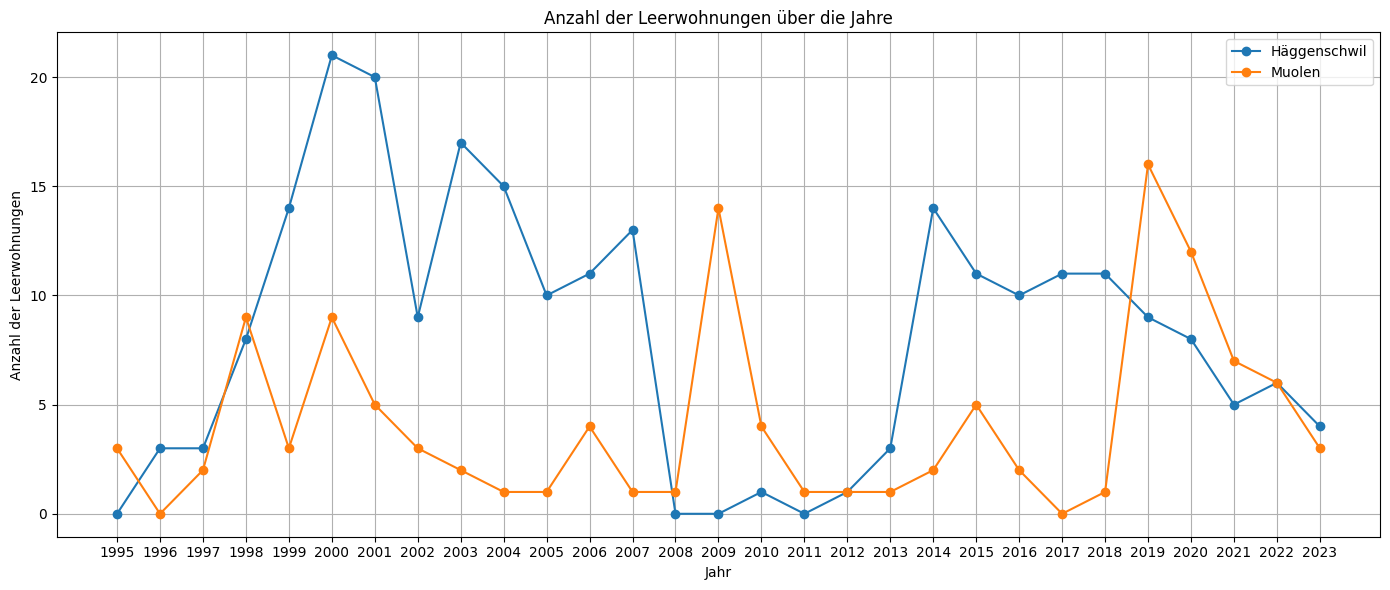

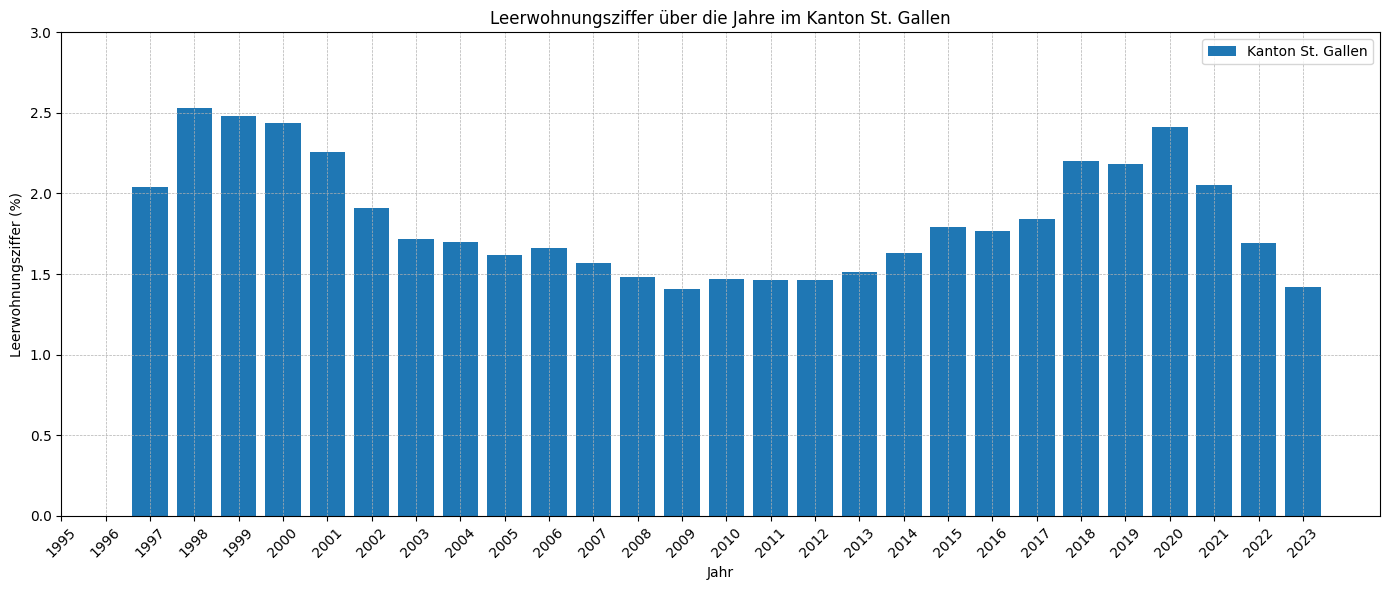

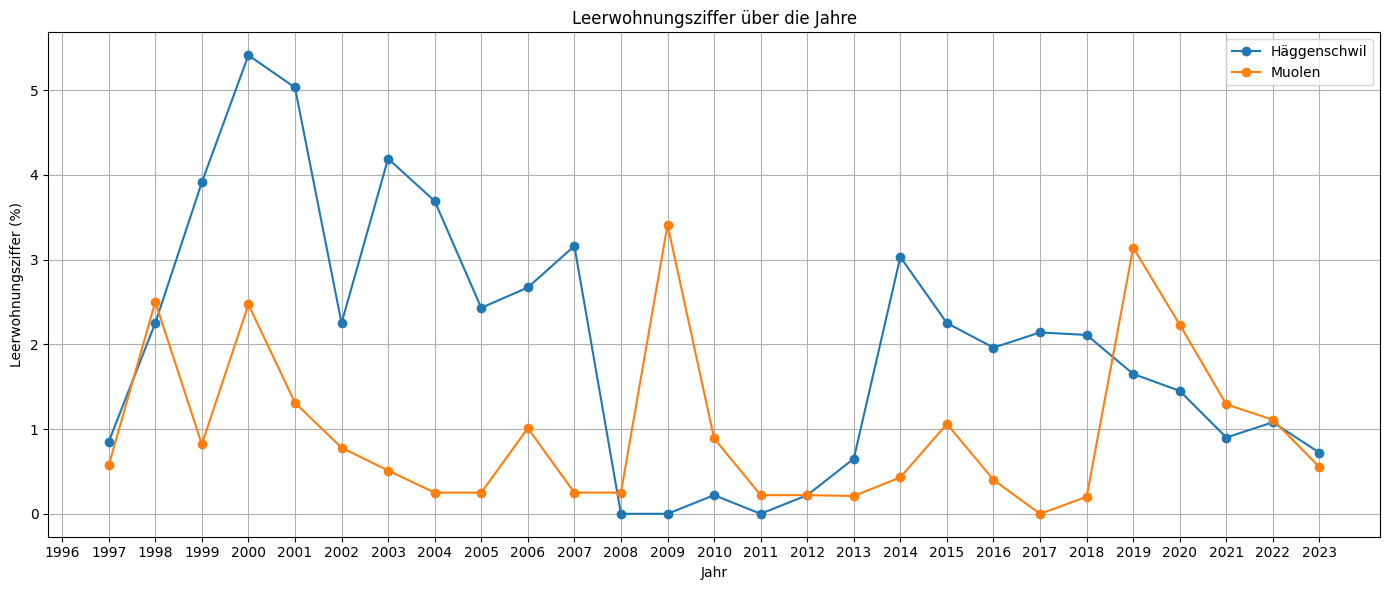

In [139]:
# Anzahl der Leerwohnungen über die Jahre
plot_line_chart(
    {
        'Häggenschwil': haeggenschwil_leerwohnungsanzahl,
        'Muolen': muolen_leerwohnungsanzahl
    },
    'Anzahl der Leerwohnungen über die Jahre',
    'Jahr',
    'Anzahl der Leerwohnungen'
)

# Leerwohnungsziffer über die Jahre
plot_bar_chart(
    {
        'Kanton St. Gallen': kanton_sg_leerwohnungsziffer
    },
    'Leerwohnungsziffer über die Jahre im Kanton St. Gallen',
    'Jahr',
    'Leerwohnungsziffer (%)'
)

plot_line_chart(
    {
        'Häggenschwil': haeggenschwil_leerwohnungsziffer,
        'Muolen': muolen_leerwohnungsziffer
    },
    'Leerwohnungsziffer über die Jahre',
    'Jahr',
    'Leerwohnungsziffer (%)'
)
